# Training VGG16

In [10]:
import os
from glob import glob
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [11]:
X_train = np.load("/home/sajedhamdan/Desktop/skin_cancer/images_train_256x192.npy")
y_train = np.load("/home/sajedhamdan/Desktop/skin_cancer/train_labels.npy")

X_val = np.load("/home/sajedhamdan/Desktop/skin_cancer/images_val_256x192.npy")
y_val = np.load("/home/sajedhamdan/Desktop/skin_cancer/val_labels.npy")


X_train.shape, X_val.shape
y_train.shape, y_val.shape

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

y_train = y_train.astype('float32')
y_val = y_val.astype('float32')


In [12]:
pretrained_model = VGG16(input_shape=(192, 256, 3), include_top=False, weights="imagenet")

for layer in pretrained_model.layers:
    print(layer.name)
    layer.trainable = False
    

input_layer_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [13]:
last_layer = pretrained_model.get_layer('block5_pool')
print('Last layer output shape:', last_layer.output.shape)
last_output = last_layer.output

Last layer output shape: (None, 6, 8, 512)


In [14]:
x = layers.GlobalMaxPooling2D()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(7, activation='softmax')(x)

model = Model(pretrained_model.input, x)
#change epsilon from NONE to 1e-7, this helps not to divide by xero
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

In [15]:
train_datagenerator = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagenerator.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)


In [16]:
batch_size = 64 
epochs = 3
history = model.fit(train_datagenerator.flow(X_train, y_train, batch_size=batch_size),
                    epochs=epochs,
                    validation_data=val_datagen.flow(X_val, y_val),
                    verbose=1,
                    steps_per_epoch=(X_train.shape[0] // batch_size),
                    validation_steps=(X_val.shape[0] // batch_size))                    


/home/sajedhamdan/Desktop/skin_cancer/myvenv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
126/126 ━━━━━━━━━━━━━━━━━━━━ 722s 6s/step - accuracy: 0.5384 - loss: 1.4679 - precision: 0.6239 - recall: 0.3981 - val_accuracy: 0.6674 - val_loss: 1.1064 - val_precision: 0.6797 - val_recall: 0.6585
Epoch 2/3
  1/126 ━━━━━━━━━━━━━━━━━━━━ 9:48 5s/step - accuracy: 0.8125 - loss: 0.6853 - precision: 0.8846 - recall: 0.7188

/home/sajedhamdan/Desktop/skin_cancer/myvenv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


126/126 ━━━━━━━━━━━━━━━━━━━━ 39s 271ms/step - accuracy: 0.8125 - loss: 0.6853 - precision: 0.8846 - recall: 0.7188 - val_accuracy: 0.6696 - val_loss: 1.0558 - val_precision: 0.6836 - val_recall: 0.6607
Epoch 3/3
126/126 ━━━━━━━━━━━━━━━━━━━━ 678s 5s/step - accuracy: 0.6598 - loss: 1.1130 - precision: 0.7192 - recall: 0.5886 - val_accuracy: 0.6496 - val_loss: 1.0486 - val_precision: 0.6966 - val_recall: 0.5893


In [17]:
for layer in model.layers[:15]:
    layer.trainable = False

for layer in model.layers[15:]:
    layer.trainable = True      

# reconfiguring and compling model
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')] )                      
              

In [22]:
# decreasing learning rate when model is stuck(not improving)
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=3)

batch_size = 64
epochs = 10
history = model.fit(train_datagenerator.flow(X_train, y_train, batch_size=batch_size),
                    epochs=epochs,
                    validation_data=val_datagen.flow(X_val, y_val),
                    verbose=1,
                    steps_per_epoch=(X_train.shape[0] // batch_size),
                    validation_steps=(X_val.shape[0] // batch_size),
                    callbacks=[lr_reduction])
                                        


results = model.evaluate(X_val, y_val, verbose=1)
loss_val = results[0]
acc_val = results[1]
precision_val = results[2]
recall_val = results[3]

print("Validation: accuracy = %f  ;  loss = %f  ;  precision = %f  ;  recall = %f"
      % (acc_val, loss_val, precision_val, recall_val))

                          

Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 813s 6s/step - accuracy: 0.8055 - loss: 0.5396 - precision: 0.8625 - recall: 0.7488 - val_accuracy: 0.7299 - val_loss: 0.7415 - val_precision: 0.7855 - val_recall: 0.7031 - learning_rate: 1.0000e-04
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 80s 590ms/step - accuracy: 0.7344 - loss: 0.7203 - precision: 0.8000 - recall: 0.6875 - val_accuracy: 0.7612 - val_loss: 0.6899 - val_precision: 0.8182 - val_recall: 0.7232 - learning_rate: 1.0000e-04
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 765s 6s/step - accuracy: 0.8076 - loss: 0.5182 - precision: 0.8653 - recall: 0.7610 - val_accuracy: 0.7812 - val_loss: 0.6346 - val_precision: 0.8215 - val_recall: 0.7500 - learning_rate: 1.0000e-04
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 39s 268ms/step - accuracy: 0.7656 - loss: 0.6905 - precision: 0.8364 - recall: 0.7188 - val_accuracy: 0.7522 - val_loss: 0.7161 - val_precision: 0.8015 - val_recall: 0.7121 - learning_rate: 1.0000e-04
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 

# Testing VGG16

In [23]:
X_test = np.load("/home/sajedhamdan/Desktop/skin_cancer/images_test_256x192.npy")

y_test = np.load("/home/sajedhamdan/Desktop/skin_cancer/test_labels.npy")
y_test = to_categorical(y_test)


results = model.evaluate(X_test, y_test, verbose=1)

# Unpack individual metrics from the results list
loss_test = results[0]
accuracy_test = results[1]
precision_test = results[2]
recall_test = results[3]

print("Test: accuracy = %f  ;  loss = %f  ;  precision = %f  ;  recall = %f"
      % (accuracy_test, loss_test, precision_test, recall_test))

model.save("VGG16.h5")

32/32 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.7688 - loss: 0.6336 - precision: 0.8213 - recall: 0.7250


Test: accuracy = 0.797405  ;  loss = 0.594207  ;  precision = 0.837444  ;  recall = 0.745509


Text(0.5, 1.0, 'Training and validation loss')

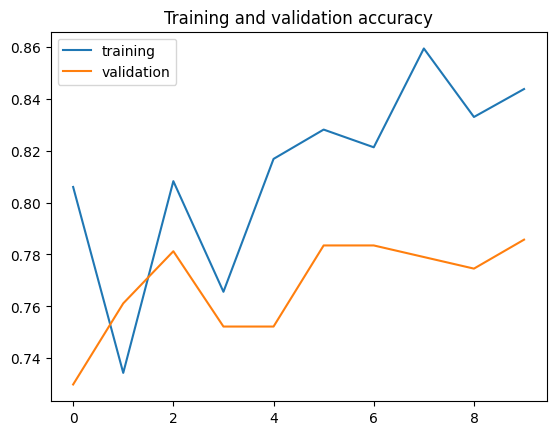

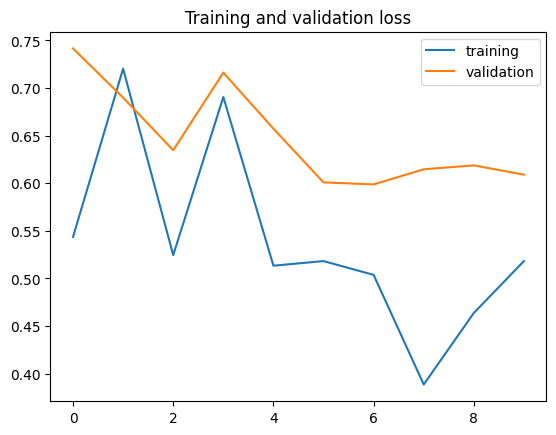

In [27]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label="training")
plt.plot(epochs, val_acc, label="validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, label="training")
plt.plot(epochs, val_loss, label="validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')
